In [15]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import distrax

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import FeedForwardNetwork


# AR2 Experiment

## Static Experiment Constants.

In [16]:
TAU = 1 / (256*8*60)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4

# Train and eval constants.
TRAIN_KEY = jax.random.key(112)
TRAIN_BATCH_SIZE = 1000
TRAIN_STEPS = 2500

EVAL_N_RUNS = 1000
EVAL_N_TIMESTEPS = 5000
EVAL_DATA_KEY = jax.random.key(65)

# NN Model Parameters
MODEL_SIZES = [
    # (1, 4),
    # (1, 16),
    (1, 64),
    # (2, 16),
    #(3, 64),
]

## Model Definiton Functions

In [80]:
SIGMA_Y = 0.64

def f_mean_func(last_val):
    return last_val + TAU * KAPPA * (X_BAR - last_val)

def f_std_func(last_val):
    return jnp.sqrt(TAU) * SIGMA_SIGMA

def g_mean_func(last_val):
    return jnp.exp(last_val)

def g_std_func(last_val):
    return jnp.sqrt(TAU) * jnp.exp(last_val)


### Creating the state functions from the above.

In [81]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = f_mean_func(last_val)
    std = f_std_func(last_val)
    
    return noise * std + means

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = g_mean_func(all_particles)
    y_stds = g_std_func(all_particles)
    
    return total_noise * y_stds + y_means

def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = f_mean_func(prev_particle)  # Mean reversion
    f_std = f_std_func(prev_particle)  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    mean = g_mean_func(particle)  # expected mean
    std = g_std_func(particle)  # full variance
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))

def transition_model(input):
    last_x, y = input
    mean = f_mean_func(last_x)
    scale = f_std_func(last_x)
    return mean, scale

### Creating the Vehicle and Particle Filter.

In [82]:
stoch_vol_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)

stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single)

# Generate test data for evaluation

print(f"Generating {EVAL_N_RUNS} runs of data with {EVAL_N_TIMESTEPS} timesteps each...")
test_input_batches, test_target_batches = stoch_vol_vehicle.generate_training_data(
    EVAL_DATA_KEY, 
    EVAL_N_RUNS,
    EVAL_N_TIMESTEPS,
    X_BAR
)

test_inputs = jnp.vstack(test_input_batches)
test_targets = jnp.hstack(test_target_batches)

def loss(model, inputs, z_i):
    log_likelihood = jax.vmap(stoch_vol_vehicle.model_weight_from_inputs, in_axes=(None, 0, 0))(model, z_i, inputs)
    return -jnp.mean(log_likelihood)

# Evaluating the Bootstrap Model:
boot_eval = loss(transition_model, test_inputs, test_targets)

Generating 1000 runs of data with 5000 timesteps each...


In [83]:
# import matplotlib.pyplot as plt

# plot_key = jax.random.key(100)
# X, Y = stoch_vol_vehicle.generate_data(plot_key, 3, 1000, X_BAR)

# fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
# fig.suptitle("Stochastic Volatility Model: X, Y, and Cumulative Y for 3 Runs", fontsize=16)

# for i in range(3):
#     # Plot X
#     axes[0, i].plot(X[i], color='tab:blue')
#     axes[0, i].set_title(f"Run {i+1}: Latent State $X_t$")
#     axes[0, i].set_ylabel("$X_t$")
#     axes[0, i].grid(True, linestyle='--', alpha=0.5)
    
#     # Plot Y
#     axes[1, i].plot(Y[i], color='tab:orange')
#     axes[1, i].set_title(f"Run {i+1}: Observation $Y_t$")
#     axes[1, i].set_ylabel("$Y_t$")
#     axes[1, i].grid(True, linestyle='--', alpha=0.5)
    
#     # Plot cumulative Y
#     axes[2, i].plot(jnp.cumsum(Y[i]), color='tab:green')
#     axes[2, i].set_title(f"Run {i+1}: Cumulative $Y_t$")
#     axes[2, i].set_xlabel("Time step")
#     axes[2, i].set_ylabel("Cumulative $Y_t$")
#     axes[2, i].grid(True, linestyle='--', alpha=0.5)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


# Training the models.


Training model 1/1: n_layers=1, hidden_dim=64


  0%|          | 0/5000 [00:00<?, ?it/s]

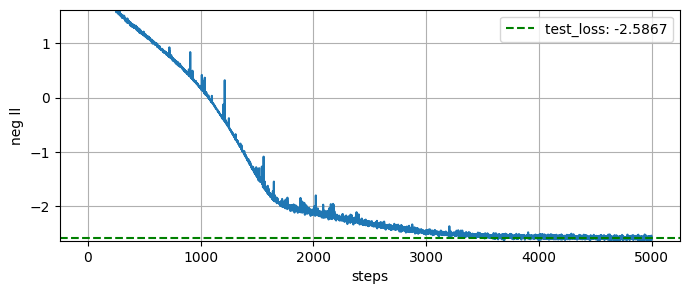

In [93]:
# Training the Feed Forward Network.

trained_models_evals = {}

for i, (n_layers, hidden_dim) in enumerate(MODEL_SIZES):
    print(f"\nTraining model {i+1}/{len(MODEL_SIZES)}: n_layers={n_layers}, hidden_dim={hidden_dim}")
    
    model = FeedForwardNetwork(n_layers, hidden_dim, jax.random.key(100 + i))
    stoch_vol_vehicle.train_model(
        TRAIN_KEY, 
        model,
        TRAIN_BATCH_SIZE, 
        learning_rate=1e-4,
        steps = 5000, 
        X_bar = X_BAR,
        noise_starting_scale = 1
    )

    model_eval = loss(stoch_vol_vehicle.unvectorized_model, test_inputs, test_targets)
    trained_models_evals[(n_layers, hidden_dim)] = model_eval


In [85]:
print('Bootstrap model eval: ', boot_eval)
print('NNP model eval: ', model_eval)


Bootstrap model eval:  -2.584716
NNP model eval:  -2.6168835


## Model had been trained. 

We now need to run the particle filter.

In [86]:
boot_particle_filter = ParticleFilter(
    f_sample_fn,
    g_likelihood_single,
    include_all_weights=True
)

nn_particle_filter = stoch_vol_vehicle.build_NN_particle_filter(
    include_all_weights=True
)

# 1. Generate the data to run the particle filter on. 

N_RUNS = 2
N_TIMESTEPS = 1000
N_PARTICLES = 2500

DATA_KEY = jax.random.key(65)
EVAL_KEY = jax.random.key(56)

# 1. Use the stochastic volatility vehicle to generate batched data 

print(f"Generating {N_RUNS} runs of data with {N_TIMESTEPS} timesteps each...")
x_vals, y_vals = stoch_vol_vehicle.generate_data(
    DATA_KEY, 
    N_RUNS,
    N_TIMESTEPS,
    X_BAR
)

INIT_PARTICLE_KEY = jax.random.key(16)
initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (N_PARTICLES,)) * 0.1 + X_BAR
initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)

# 2. Run the particle filters

# Bootstrap Particle Filter
print("Running bootstrap particle filter simulations...")
_, _, bootstrap_diagnostics, bootstrap_output_particles_and_weights = jax.vmap(
    boot_particle_filter.simulate, in_axes=(0, None, None, 0, 0)
)(
    jax.random.split(EVAL_KEY, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)

# Neural Network Particle Filter
print("Running neural network particle filter simulations...")
_, _, nn_diagnostics, nn_output_particles_and_weights = jax.vmap(
    nn_particle_filter.simulate, in_axes=(0, None, None, 0, 0)
)(
    jax.random.split(EVAL_KEY, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)


Generating 2 runs of data with 1000 timesteps each...
Running bootstrap particle filter simulations...
Running neural network particle filter simulations...


Look at the ess values for the nn_particle_filter

Mean ESS (Neural Network PF): 381.96
Mean ESS (Bootstrap PF): 371.20


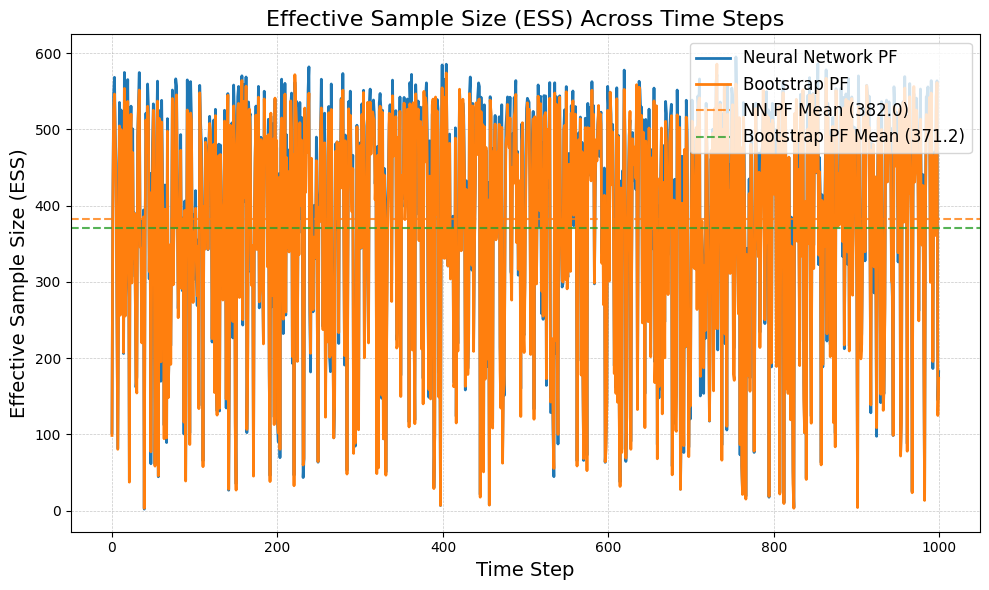

In [87]:
import matplotlib.ticker as mticker

# Calculate mean ESS for each filter
mean_ess_nn = jnp.mean(nn_diagnostics['ess'][0])
mean_ess_bootstrap = jnp.mean(bootstrap_diagnostics['ess'][0])

print(f"Mean ESS (Neural Network PF): {mean_ess_nn:.2f}")
print(f"Mean ESS (Bootstrap PF): {mean_ess_bootstrap:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(nn_diagnostics['ess'][0], label='Neural Network PF', linewidth=2)
plt.plot(bootstrap_diagnostics['ess'][0], label='Bootstrap PF', linewidth=2)

# Plot mean ESS as horizontal lines
plt.axhline(mean_ess_nn, color='C1', linestyle='--', linewidth=1.5, alpha=0.8,
            label=f'NN PF Mean ({mean_ess_nn:.1f})')
plt.axhline(mean_ess_bootstrap, color='C2', linestyle='--', linewidth=1.5, alpha=0.8,
            label=f'Bootstrap PF Mean ({mean_ess_bootstrap:.1f})')

plt.title("Effective Sample Size (ESS) Across Time Steps", fontsize=16)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Effective Sample Size (ESS)", fontsize=14)
plt.legend(fontsize=12, loc='upper right', frameon=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [88]:
arg_sorted_nn_ess = np.argsort(nn_diagnostics['ess'][0])
first_three = arg_sorted_nn_ess[:3]
last_three = arg_sorted_nn_ess[-3:]
rand_three = np.random.choice(arg_sorted_nn_ess, 3, replace=False)

In [89]:
print(first_three)
print(last_three)
print(rand_three)


[ 39 824 901]
[404 853 754]
[926 790 744]


Now that we have evaluated the particle filter we should begin writing the QQ-plot function

In [90]:
def create_qq_plot(output_particles_and_weights, x_vals, y_vals, point_to_plot, nn_ess, boot_ess, boot_particles_and_weights):
    # 1. Unpack the particles and weights.
    particles, weights = output_particles_and_weights
    particles, weights = particles.at[point_to_plot].get(), weights.at[point_to_plot].get()
    particles, weights = np.array(particles), np.array(weights)

    # Unpack bootstrap particles and weights
    boot_particles, boot_weights = boot_particles_and_weights
    boot_particles, boot_weights = boot_particles.at[point_to_plot].get(), boot_weights.at[point_to_plot].get()
    boot_particles, boot_weights = np.array(boot_particles), np.array(boot_weights)

    x_vals = np.array(x_vals)
    prev_x = x_vals[point_to_plot - 1]
    true_x = x_vals[point_to_plot]
    
    # 2. Prepare for QQ-plot.
    quantiles_to_take = np.linspace(0, 1, 100)
    quantiles_of_interest = np.quantile(particles, quantiles_to_take, axis=0, method='inverted_cdf', weights=weights)

    # 3. True distribution. 
    # Bootstrap
    true_mean, true_std = f_mean_func(prev_x), f_std_func(prev_x)
    true_quantiles = stats.norm.ppf(quantiles_to_take, true_mean, true_std)
    
    # Quantile of the true value under the NNP proposal (particle filter)
    # This is the weighted CDF of the particles at true_x
    def weighted_cdf(x, samples, weights):
        # Returns the weighted CDF value at x
        idx = np.argsort(samples)
        samples_sorted = samples[idx]
        weights_sorted = weights[idx]
        cum_weights = np.cumsum(weights_sorted)
        cum_weights = cum_weights / cum_weights[-1]
        # Find where true_x would be inserted
        insert_idx = np.searchsorted(samples_sorted, x, side='right')
        if insert_idx == 0:
            return 0.0
        elif insert_idx >= len(samples_sorted):
            return 1.0
        else:
            return cum_weights[insert_idx-1]
    nnp_true_x_quantile = weighted_cdf(true_x, particles, weights)

    # 4. Make the plot (2x2 grid, using all 4 subplots)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    # Subplot 1: QQ plot (Bootstrap)
    axes[0].plot(quantiles_of_interest, true_quantiles, marker='o', linestyle='', label='Particle Quantiles')
    axes[0].plot(true_quantiles, true_quantiles, 'k--', label='y=x (Ideal)')
    # Add the true_x as a red star on the QQ plot
    true_x_quantile = stats.norm.cdf(true_x, loc=true_mean, scale=true_std)
    pf_quantile = np.quantile(particles, true_x_quantile, method='inverted_cdf', weights=weights)
    axes[0].plot(pf_quantile, stats.norm.ppf(true_x_quantile, true_mean, true_std), 'r*', markersize=15, label='True $x_t$')
    axes[0].set_title(f'QQ Plot (Bootstrap) at t={point_to_plot}')
    axes[0].set_xlabel('NNP Proposals Quantiles')
    axes[0].set_ylabel('Bootstrap Quantiles')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].text(
        0.05, 0.95, 
        f"NN ESS: {nn_ess:.2f}\nBoot ESS: {boot_ess:.2f}\n"
        f"True $x_t$ quantile (bootstrap): {true_x_quantile:.3f}\n"
        f"True $x_t$ quantile (NNP): {nnp_true_x_quantile:.3f}",
        transform=axes[0].transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    # Subplot 2: Cumulative sorted weight function (NNP)
    sorted_indices = np.argsort(weights)
    sorted_weights = weights[sorted_indices]
    cum_weights = np.cumsum(sorted_weights)
    cum_weights /= cum_weights[-1]  # Normalize to 1

    axes[1].plot(cum_weights, label='Cumulative Weight (NNP)')
    n = len(cum_weights)
    axes[1].plot(np.linspace(0, n-1, n), np.linspace(0, 1, n), 'k--', label='y=x (Ideal)')
    axes[1].set_title(f'Cumulative Sorted Weight Function at t={point_to_plot}')
    axes[1].set_xlabel('Particle Index (sorted)')
    axes[1].set_ylabel('Cumulative Weight')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].text(
        0.05, 0.95, f"NN ESS: {nn_ess:.2f}",
        transform=axes[1].transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    # Subplot 3: Weighted histogram of NNP particles
    x_min = min(np.min(particles), np.min(boot_particles))
    x_max = max(np.max(particles), np.max(boot_particles))
    x_grid = np.linspace(x_min, x_max, 200)
    axes[2].hist(particles, bins=30, weights=weights, alpha=0.7, color='tab:blue', edgecolor='black', label='NNP Weighted Particles')
    axes[2].plot(x_grid, stats.norm.pdf(x_grid, true_mean, true_std) * np.sum(weights) * (x_max-x_min)/30, 
                 color='tab:orange', lw=2, label='Bootstrap PDF')
    axes[2].axvline(true_x, color='red', linestyle='--', label='True $x_t$')
    true_y = y_vals[point_to_plot]
    axes[2].set_title(f'NNP Weighted Particle Histogram at t={point_to_plot}')
    axes[2].set_xlabel('Particle Value')
    axes[2].set_ylabel('Weighted Count')
    axes[2].legend()
    axes[2].grid(True)
    axes[2].annotate(
        f"True $y_t$ = {true_y:.3f}",
        xy=(0.98, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        color='purple',
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    # Subplot 4: Weighted histogram of Bootstrap particles
    axes[3].hist(boot_particles, bins=30, weights=boot_weights, alpha=0.7, color='tab:green', edgecolor='black', label='Bootstrap Weighted Particles')
    axes[3].plot(x_grid, stats.norm.pdf(x_grid, true_mean, true_std) * np.sum(boot_weights) * (x_max-x_min)/30, 
                 color='tab:orange', lw=2, label='Bootstrap PDF')
    axes[3].axvline(true_x, color='red', linestyle='--', label='True $x_t$')
    axes[3].set_title(f'Bootstrap Weighted Particle Histogram at t={point_to_plot}')
    axes[3].set_xlabel('Particle Value')
    axes[3].set_ylabel('Weighted Count')
    axes[3].legend()
    axes[3].grid(True)
    axes[3].annotate(
        f"True $y_t$ = {true_y:.3f}",
        xy=(0.98, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        color='purple',
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    plt.tight_layout()
    plt.show()

worst


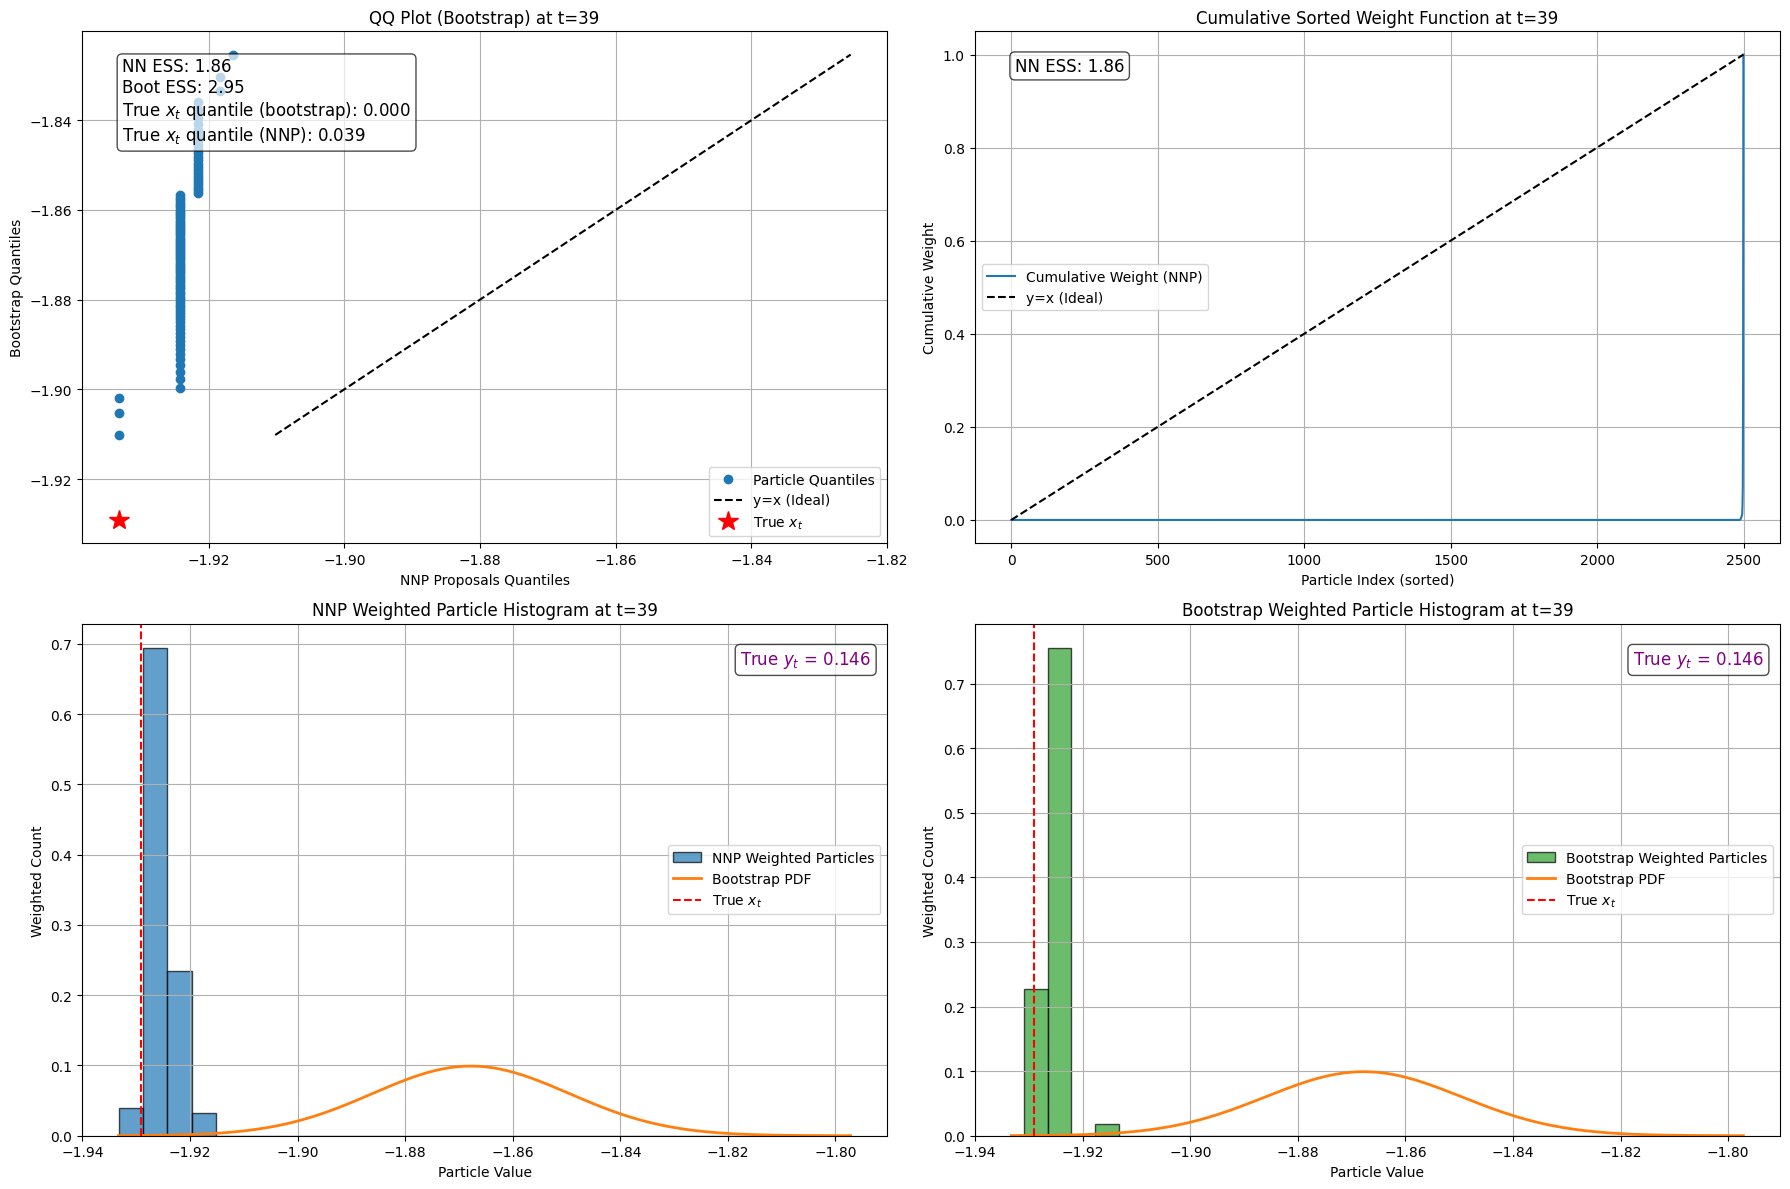

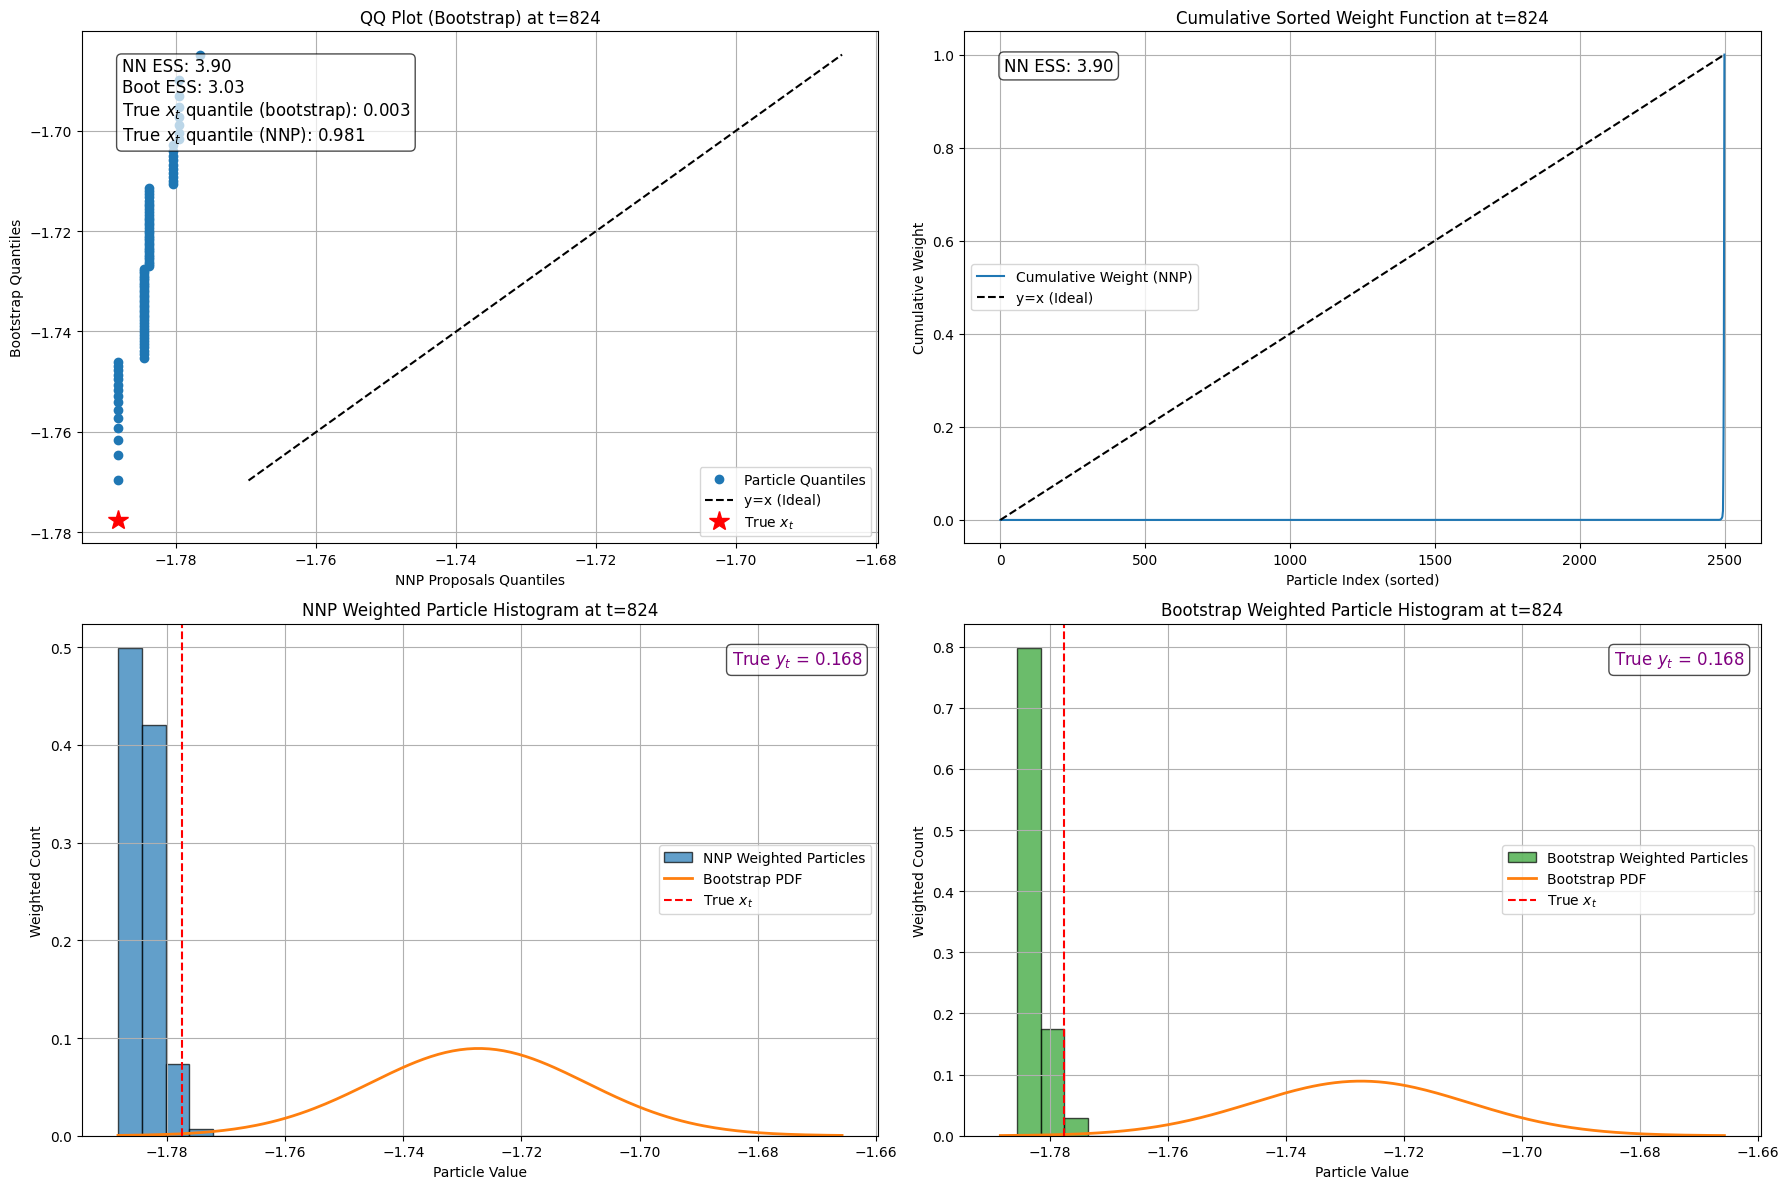

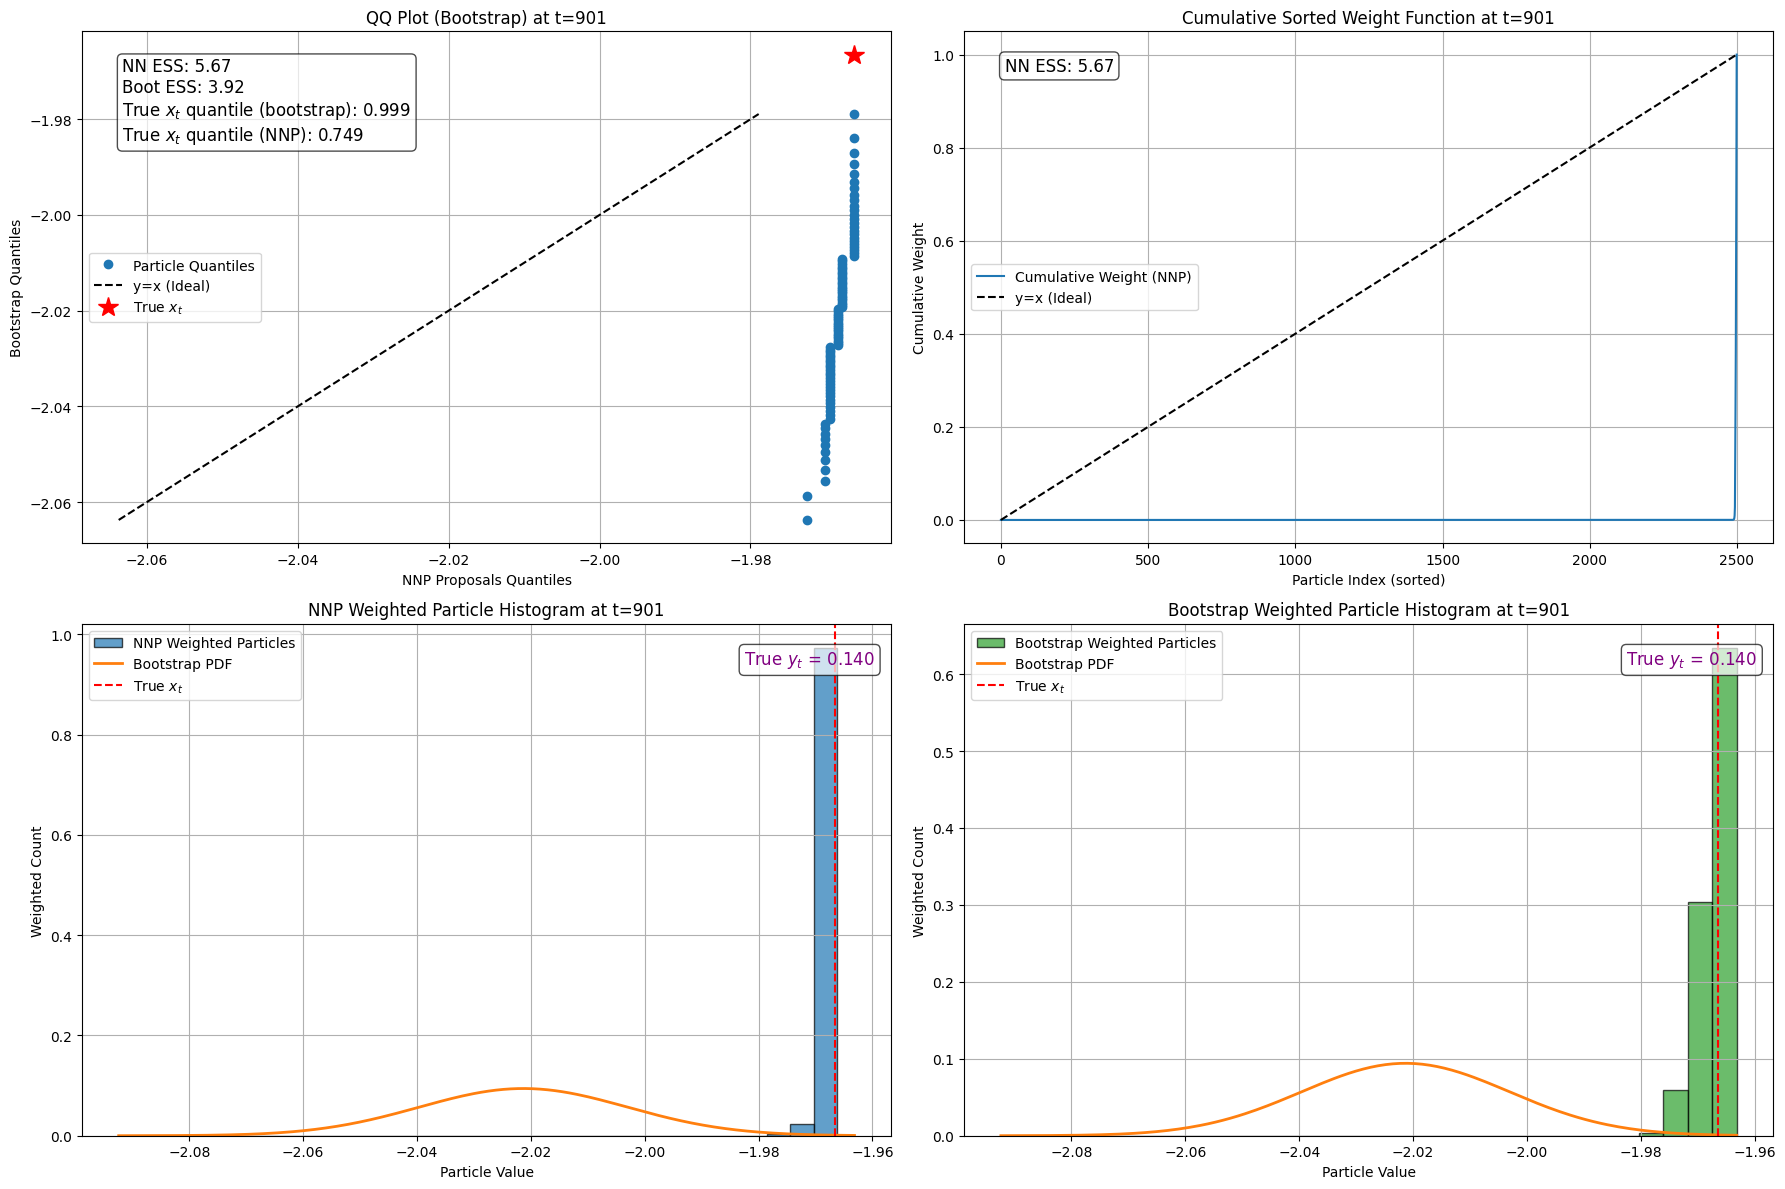

best


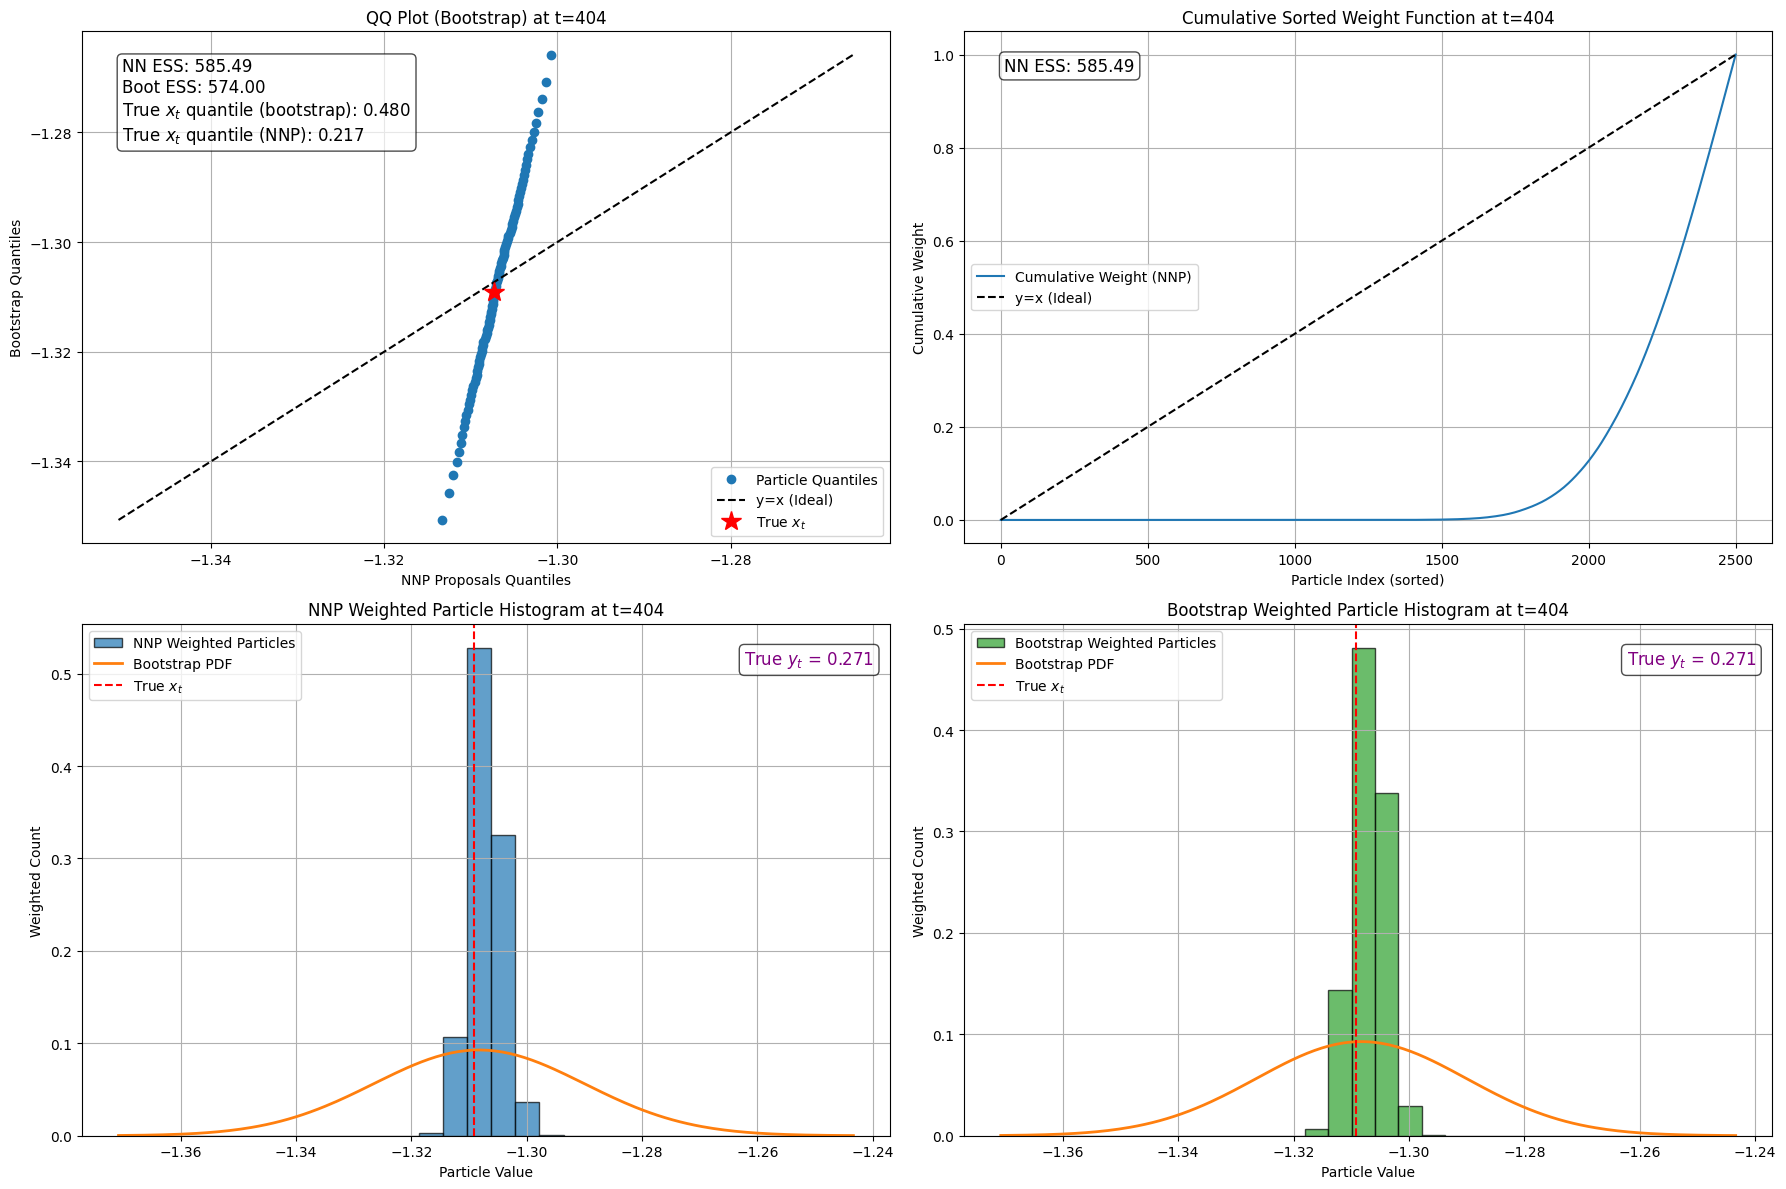

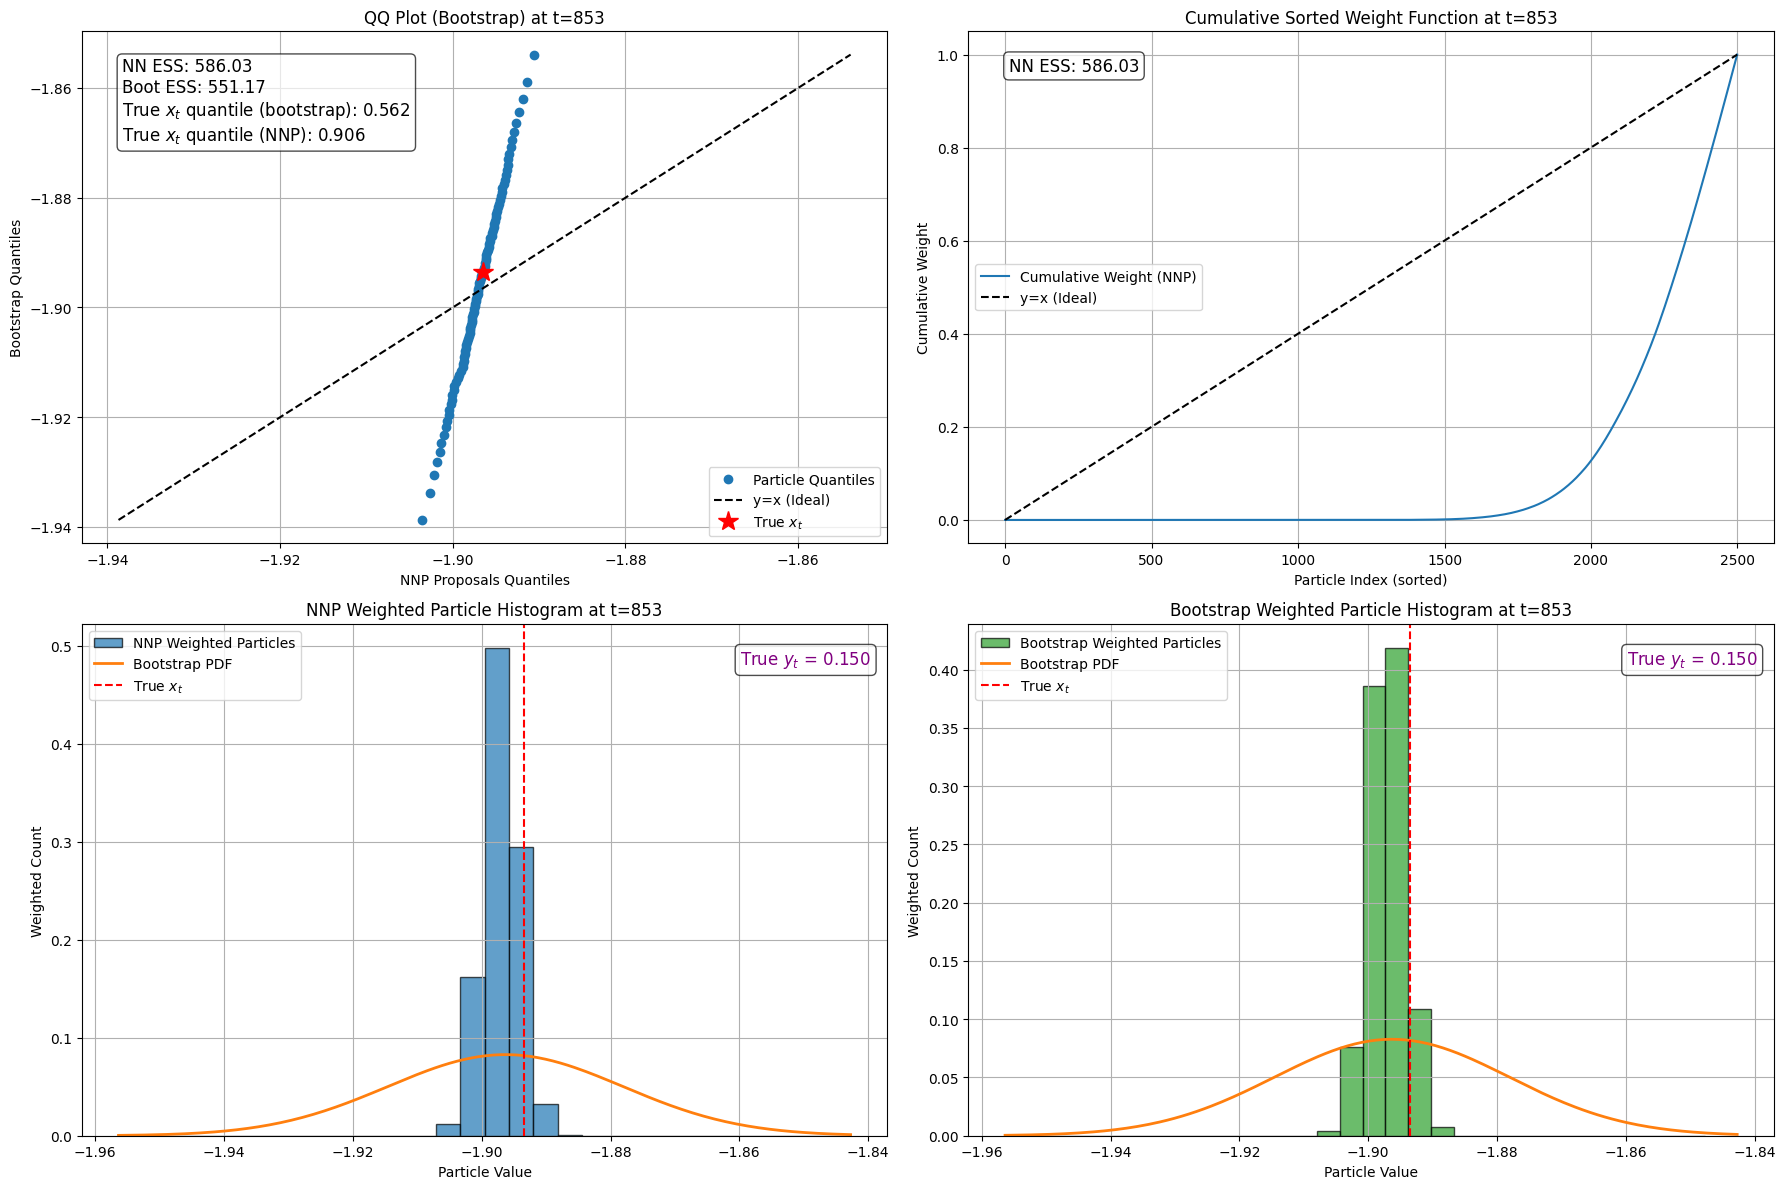

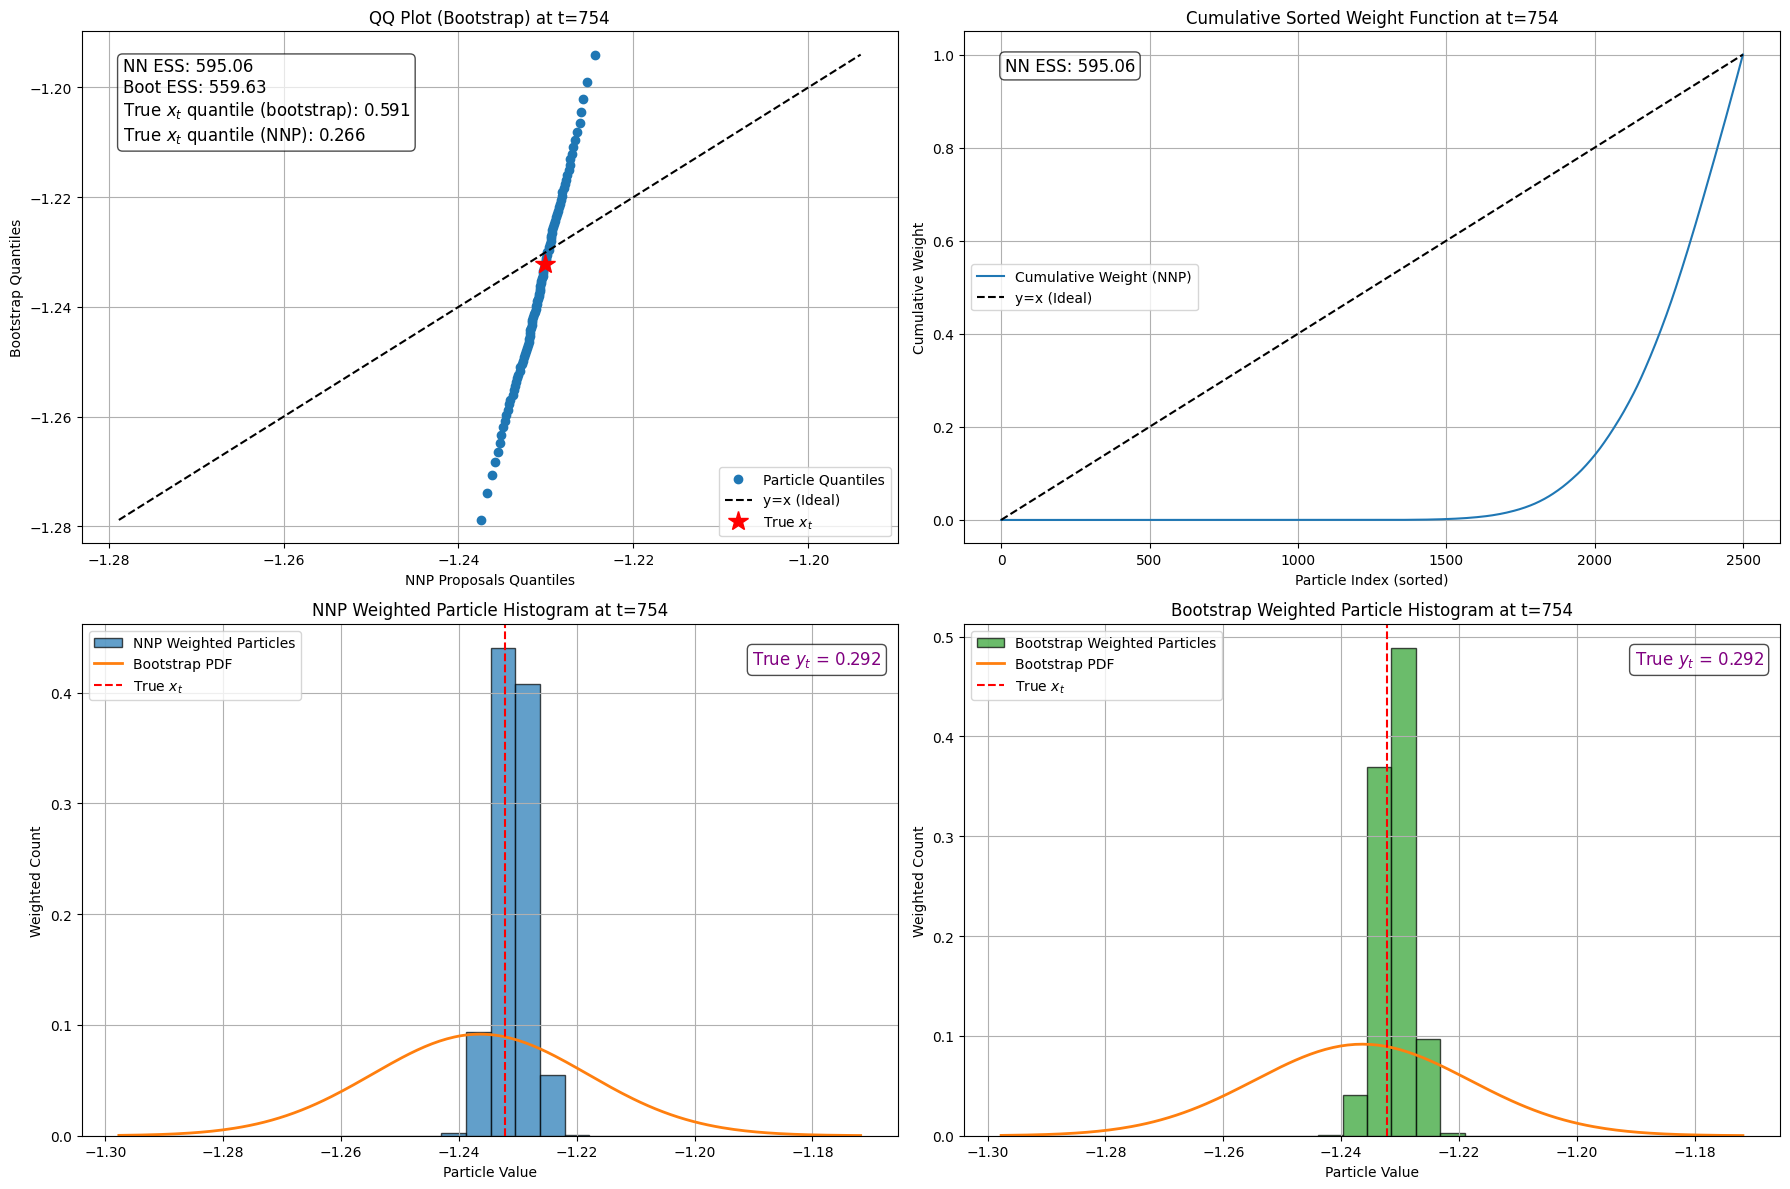

random


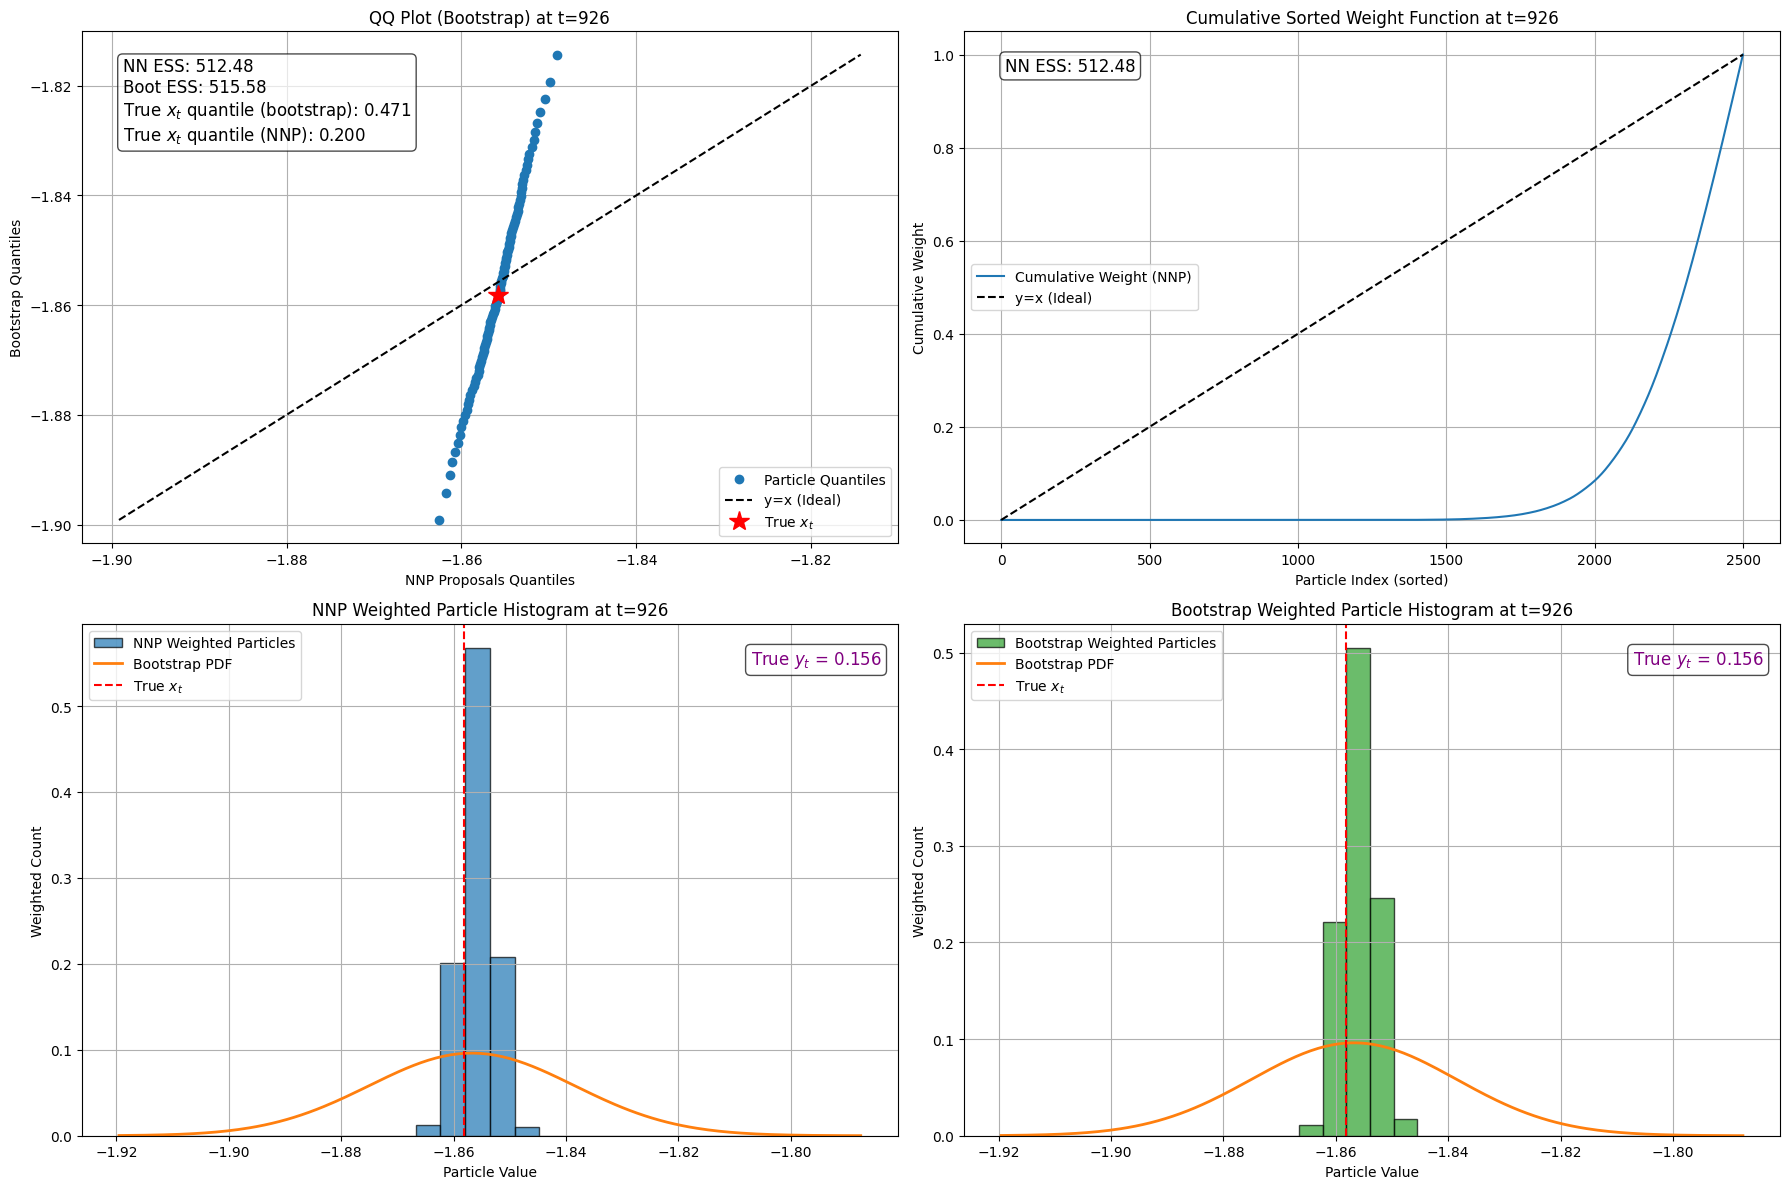

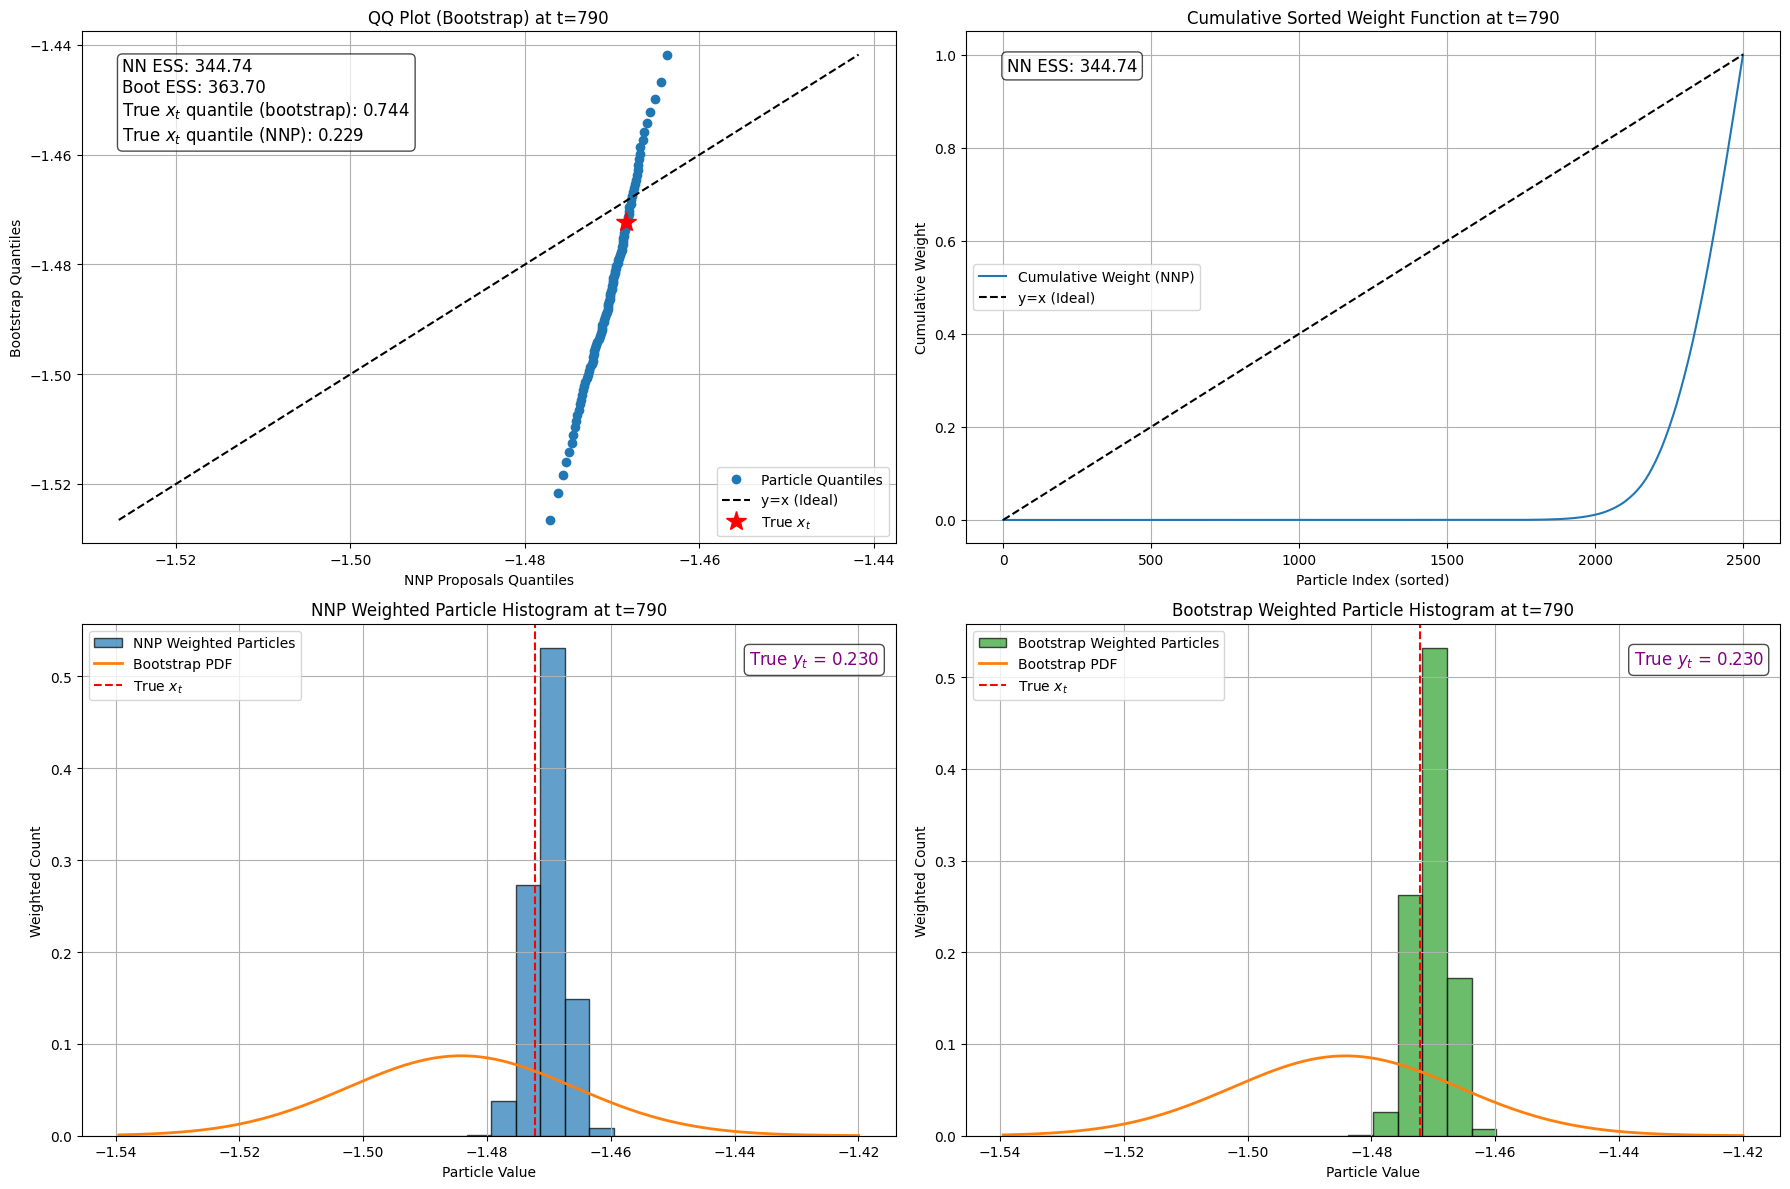

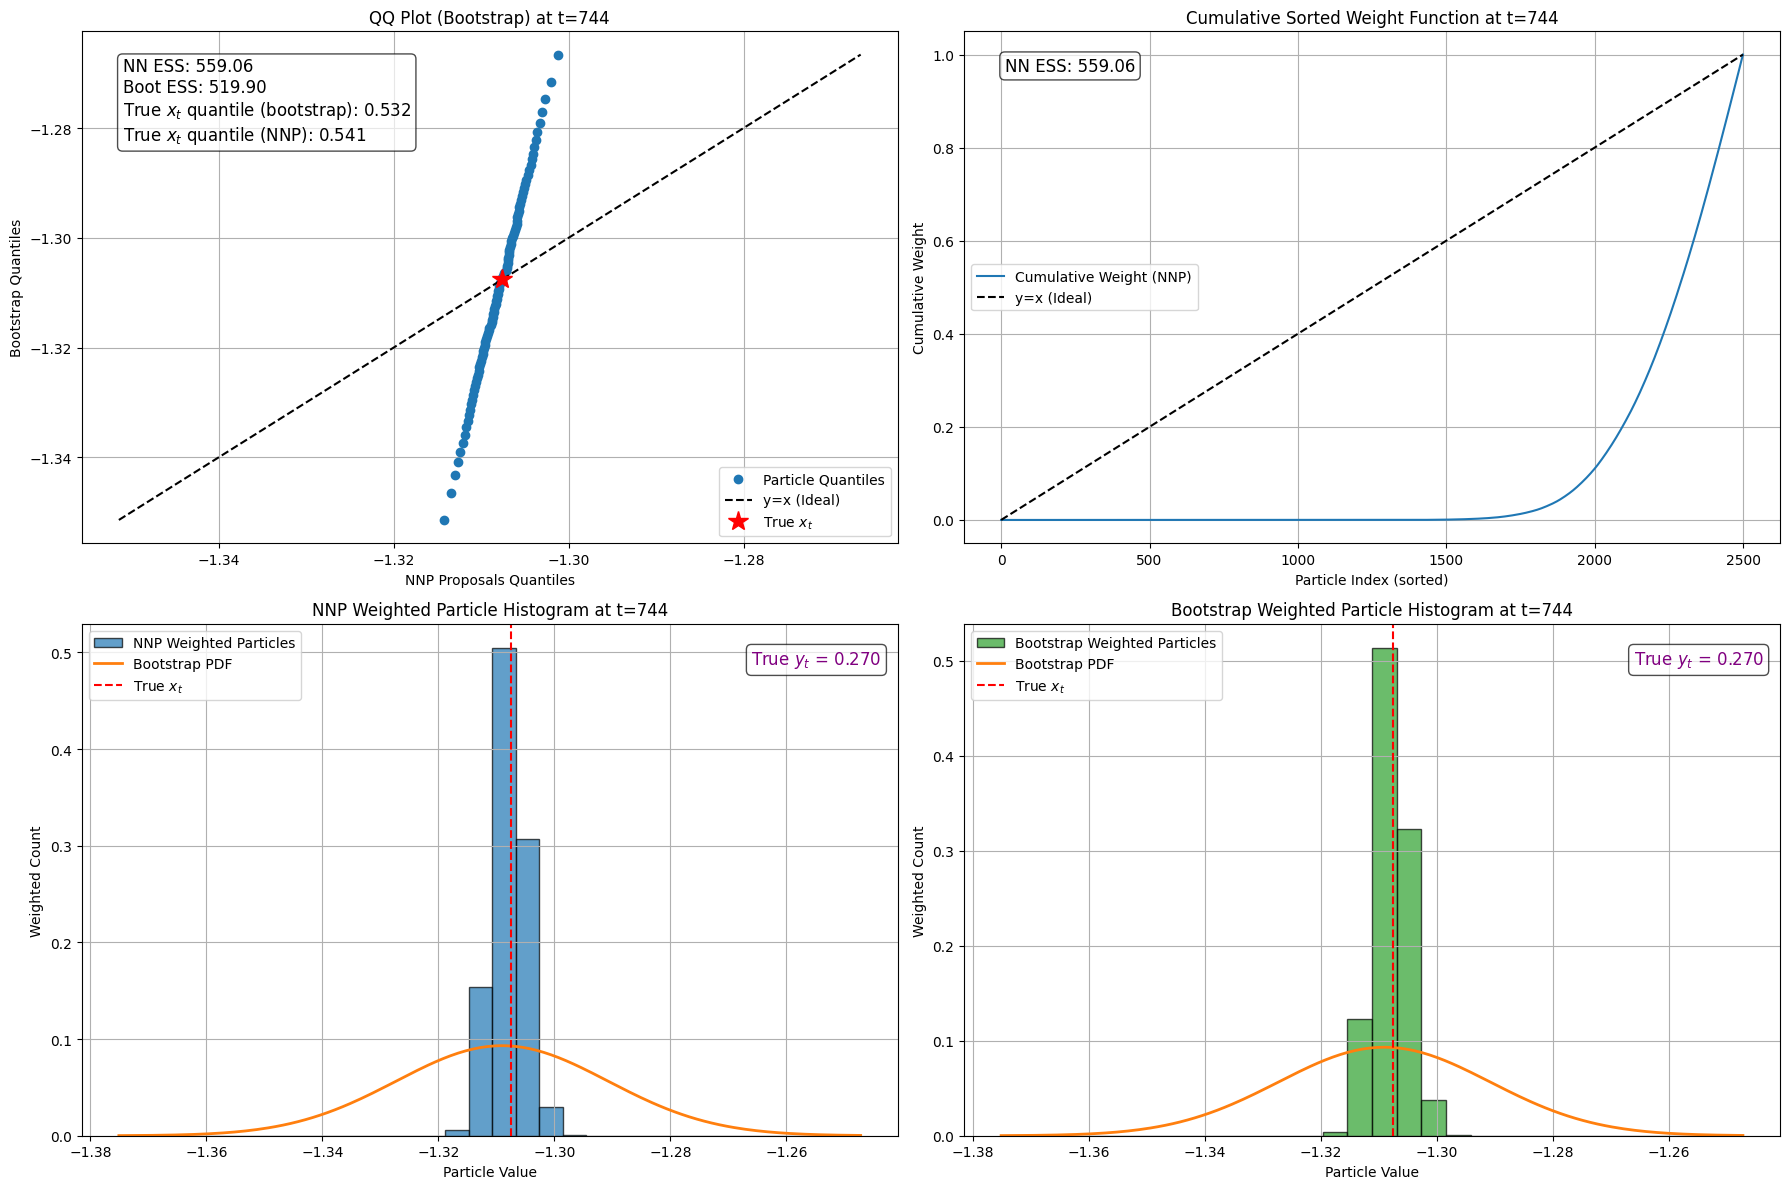

In [91]:
all_particles, all_weights = nn_output_particles_and_weights
first_particles, first_weights = all_particles[0], all_weights[0]

boot_particles, boot_weights = bootstrap_output_particles_and_weights
first_boot_particles, first_boot_weights = boot_particles[0], boot_weights[0]

nn_ess = nn_diagnostics['ess'][0]
boot_ess = bootstrap_diagnostics['ess'][0]

print('worst')
for idx in first_three:
    create_qq_plot(
        (first_particles, first_weights),
        x_vals[0], y_vals[0], idx,
        nn_ess[idx], boot_ess[idx],
        (first_boot_particles, first_boot_weights)
    )

print('best')
for idx in last_three:
    create_qq_plot(
        (first_particles, first_weights),
        x_vals[0], y_vals[0], idx,
        nn_ess[idx], boot_ess[idx],
        (first_boot_particles, first_boot_weights)
    )

print('random')
for idx in rand_three:
    create_qq_plot(
        (first_particles, first_weights),
        x_vals[0], y_vals[0], idx,
        nn_ess[idx], boot_ess[idx],
        (first_boot_particles, first_boot_weights)
    )